<a href="https://colab.research.google.com/github/clionelove123/temp_test/blob/main/Chap_02_Pytorch_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [26]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


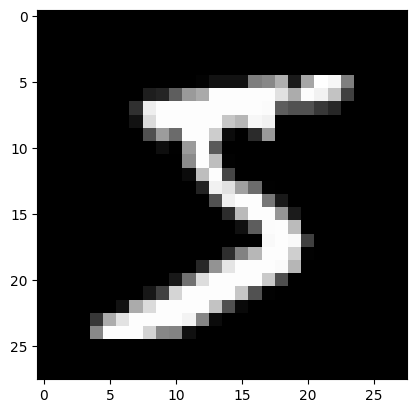

In [27]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [28]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [29]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [30]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [31]:
bs = 64  # 배치 크기

xb = x_train[0:bs]  # x로부터 미니배치(mini-batch) 추출
preds = model(xb)  # 예측
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.5665, -2.0276, -1.6974, -2.1140, -2.5299, -2.4711, -2.8903, -2.3890,
        -2.6289, -2.2631], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [32]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [33]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3921, grad_fn=<NegBackward0>)


In [34]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [35]:
print(accuracy(preds, yb))

tensor(0.0938)


In [36]:
from IPython.core.debugger import set_trace

lr = 0.5  # 학습률(learning rate)
epochs = 5  # 훈련에 사용할 에폭(epoch) 수

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
    print(loss_func(model(xb), yb), accuracy(model(xb), yb))


tensor(0.1102, grad_fn=<NegBackward0>) tensor(1.)
tensor(0.0807, grad_fn=<NegBackward0>) tensor(1.)
tensor(0.0702, grad_fn=<NegBackward0>) tensor(1.)
tensor(0.0648, grad_fn=<NegBackward0>) tensor(1.)
tensor(0.0616, grad_fn=<NegBackward0>) tensor(1.)


In [37]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0616, grad_fn=<NllLossBackward0>) tensor(1.)


In [38]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2306, grad_fn=<NllLossBackward0>)


In [39]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
        print(loss_func(model(xb), yb))

fit()
print(loss_func(model(xb), yb))

tensor(0.1088, grad_fn=<NllLossBackward0>)
tensor(0.0810, grad_fn=<NllLossBackward0>)
tensor(0.0709, grad_fn=<NllLossBackward0>)
tensor(0.0657, grad_fn=<NllLossBackward0>)
tensor(0.0625, grad_fn=<NllLossBackward0>)
tensor(0.0625, grad_fn=<NllLossBackward0>)


In [40]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

model = Mnist_Logistic()
print(loss_func(model(xb), yb))

fit()
print(loss_func(model(xb), yb))

tensor(2.3279, grad_fn=<NllLossBackward0>)
tensor(0.1121, grad_fn=<NllLossBackward0>)
tensor(0.0823, grad_fn=<NllLossBackward0>)
tensor(0.0716, grad_fn=<NllLossBackward0>)
tensor(0.0661, grad_fn=<NllLossBackward0>)
tensor(0.0626, grad_fn=<NllLossBackward0>)
tensor(0.0626, grad_fn=<NllLossBackward0>)


In [41]:
from torch import optim

In [42]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3666, grad_fn=<NllLossBackward0>)
tensor(0.0625, grad_fn=<NllLossBackward0>)


In [43]:
from torch.utils.data import TensorDataset

In [44]:
train_ds = TensorDataset(x_train, y_train)

In [45]:
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

In [46]:
xb,yb = train_ds[i*bs : i*bs+bs]

In [47]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0625, grad_fn=<NllLossBackward0>)


In [48]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [49]:
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)

In [50]:
for xb,yb in train_dl:
    pred = model(xb)

In [51]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0618, grad_fn=<NllLossBackward0>)


In [52]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [53]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3189)
1 tensor(0.3606)
2 tensor(0.3417)
3 tensor(0.3146)
4 tensor(0.2692)


In [54]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [55]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [56]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [57]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3109920261383057
1 0.34558628262877467
2 0.3134971893191338
3 0.2893532993018627
4 0.29283371037840844
